# Introduction

In this problem set, you will accomplish the following objectives:
* Apply GRU for fitting a stress-strain relationship.
* Study the hyperparameter of GRU for fitting a stress-strain relationship.


The code template for training the network is available in Lab7 notebook. You do not have to show it in your submission.

You are encouraged to start this assignment early.

In [1]:
import torch, time, copy
import torch.nn as nn
import numpy as np
import sklearn as skl
import matplotlib.pyplot as plt
import shutil

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

global device, print_freq
print_freq = 50
device = torch.device('cpu')

# Problem -- GRU for modeling path-dependent stress-strain behavior

---

In the lab session, we introduced the usage of LSTM. GRU is a more simple recurrent network architecture, which propagates hidden states but not the cell state of LSTM (in other words, $a^{<t>}=c^{<t>})$. In this problem, we want to build a recurrent network with GRU cells to predict the 2D stress-strain relationship. This problem is similar to Lab7, with the difference that you will use GRU architecture instead of LSTM. 

Use the class torch.nn.GRU to append GRU layers. The document of GRU is at https://pytorch.org/docs/stable/generated/torch.nn.GRU.html. You will find the attributes of GRU are almost the same as those in LSTM.

**a)** Define the recurrent network class with GRU layers. The architecture of the network is

\begin{matrix}
input\\
GRU (n_{l}\ layers,\ C_{hid}\ hidden\ states)\\
leaky\ ReLU\\
linear\ layer\\
output
\end{matrix}


You need to make your constructor capable of customizing the number of layers $n_l$ and the number of features in the hidden states $C_{hid}$.

In [2]:
class GRU_RNN(torch.nn.Module):

    def __init__(self, hyper_params):
        super().__init__()

        # assign hyperparameters
        input_size       = hyper_params['input_size']
        self.hidden_size = hyper_params['hidden_size']
        self.num_layers  = hyper_params['num_layers']
        output_size      = hyper_params['output_size']

        self.leakrelu    = torch.nn.LeakyReLU()
        self.GRU         = torch.nn.GRU(input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.fc1         = torch.nn.Linear(self.hidden_size, output_size)

    # x [batch size, seq length, input size]
    # h [num_layers, batch size, input size]
    
    def forward(self, x):
        
        # initialize the hidden state
        # Remark: the shape of h0 and c0 should keep the number of layers at first.
        # This is compulsory even though I think it's not a good implementation...
        a0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(device)
        
        # forward propagate the input through the 2 layer GRU
        out, a = self.GRU(x, a0)

        # leaky relu
        out = self.leakrelu(out)

        # fully connected layer
        out = self.fc1(out)
        
        return out

**b)** Let your network forward propagate a $N\times T\times C_{input}$ tensor drawn from the standard normal distribution (using `torch.normal()`). Check if the output has the correct shape $N\times T\times 3$. Here $T$ is the number of total time steps and $N$ is the number of samples in each batch, $C_{input}$ is the number of features in the input, and 3 is the number of stress components in the output.


In [3]:
N      = 50 
T      = 40
Cinput = 7

hyper_params = {'input_size': 7, 
               'hidden_size': 40, 
               'num_layers':  2,
               'output_size': 3}

x      = torch.normal(0, 1, size=(N, T, Cinput))
MyGRU  = GRU_RNN(hyper_params).to(device)
y      = MyGRU(x)

print(y.shape)

torch.Size([50, 40, 3])


**c)** Implement this GRU network. Use the program of Lab 7 Part I and the same stress-strain dataset to train a GRU network. Use a GRU object with 2 layers and 40 hidden states. Other hyperparameters (e.g., epochs, learning rate, etc.) can be the same as Lab7. Plot the training/test loss vs epochs.

The stress-strain dataset is available at https://drive.google.com/drive/folders/1GRexZFqnSoKsF0Isy-wmyaN0wFAyeft_?usp=sharing.


After you get the shared dataset, right click the dataset and add shortcuts for the shared files. Then you can import the dataset directly without downloading it.

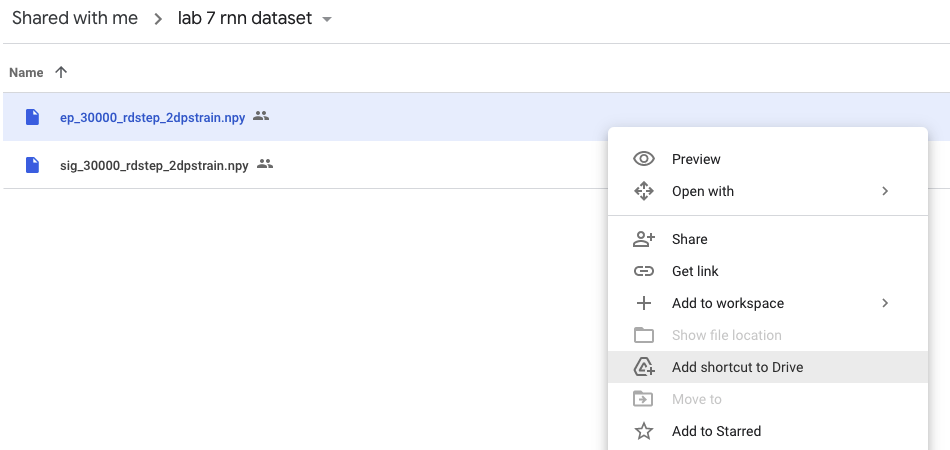

In [4]:
#@title Data preprocessing: min-max scaler
# loading the matlab format data and then convert it to an array
class MinMax_Scaler(object):

    def __init__(self, data, keep_data=False):
        self.min = np.min(data, axis=(0, 1), keepdims=True)
        self.max = np.max(data, axis=(0, 1), keepdims=True)

        if keep_data is True:
            self.data = self.transform(data, tensor=False)
        else:
            self.data = []

    def transform(self, data, tensor_format=False):
        if tensor_format is False:
            data = (data - self.min) / (self.max - self.min)
        else:
            min_tensor = torch.tensor(self.min).to(device)
            max_tensor = torch.tensor(self.max).to(device)
            for c in range(data.shape[2]):
                data[:, :, c] = torch.div(torch.sub(data[:, :, c], min_tensor[0, 0, c]), torch.sub(max_tensor[0, 0, c], min_tensor[0, 0, c]))
        return data

    def inv_transform(self, data, tensor_format=False):
        if tensor_format is False:
            data = data * (self.max - self.min) + self.min
        else:
            min_tensor = torch.tensor(self.min).to(device)
            max_tensor = torch.tensor(self.max).to(device)
            for c in range(data.shape[2]):
                data[:, :, c] = torch.add(torch.mul(data[:, :, c], torch.sub(max_tensor[0, 0, c], min_tensor[0, 0, c])), min_tensor[0, 0, c])
        return data

In [5]:
#@title Auxiliary classes: Data set, Average meter, customized loss function
class MyDataset(torch.utils.data.Dataset):

    def __init__(self, strain, stress):
        self.strain = strain
        self.stress = stress

    def __len__(self):
        return self.strain.shape[0]

    def __getitem__(self, index):
        return self.strain[index], self.stress[index]


class AverageMeter(object):
    # Computes and stores the average and current value

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def customized_loss(output, target):

    mse = torch.nn.MSELoss()

    output1 = output[:, :, 0:3]
    output2 = output[:, :, 3:6]

    target1 = target[:, :, 0:3]
    target2 = target[:, :, 3:6]

    return 0.5 * torch.maximum(mse(output1, target1), mse(output2, target2))

In [6]:
#@title train_step(), test_step()
def train_step(train_loader, model, criterion, optimizer, epoch, net_info):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        input = input.to(device)
        target = target.to(device)

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # measure accuracy and record loss
        losses.update(loss.item(), input.size(0))

        # compute gradient and do the SGD step
        optimizer.zero_grad()
        loss.backward()

        # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if epoch % 10 == 0:

            if i % print_freq == 0:
                curr_lr = optimizer.param_groups[0]['lr']
                print('Epoch: [{0}/{1}][{2}/{3}]\t'
                    'LR: {4}\t'
                    'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                    'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                    'Loss {loss.val:.7f} ({loss.avg:.6f})\t'.format(
                    epoch, net_info['epochs'], i, len(train_loader), curr_lr,
                    batch_time=batch_time, data_time=data_time, loss=losses))

    return losses.avg


def test_step(test_loader, model, criterion, epoch):
    batch_time = AverageMeter()
    losses = AverageMeter()
    # violation = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (input, target) in enumerate(test_loader):

        input = input.to(device)
        target = target.to(device)

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # measure accuracy and record loss
        losses.update(loss.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if epoch % 10 == 0:
            if i % print_freq == 0:
                print('Test: [{0}/{1}]\t'
                    'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                    'Loss {loss.val:.7f} ({loss.avg:.4f})\t'.format(
                    i, len(test_loader), batch_time=batch_time, loss=losses))

    return losses.avg

In [7]:
#@title train_RNN()
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')


def train_RNN(model, net_info, train_loader, test_loader):

    epochs = net_info['epochs']
    train_losses = np.empty([epochs, 1])
    test_losses = np.empty([epochs, 1])

    min_loss = 1e4

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=net_info['lr0'])

    for epoch in range(epochs):
        # adjust learning rate
        if epoch >= 50:
            if epoch % 50 == 0:
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= net_info['lr_decay']

        # train for one epoch
        train_losses_temp = train_step(train_loader, model, criterion, optimizer, epoch, net_info)
        train_losses[epoch] = train_losses_temp

        # evaluate on test set
        test_losses_temp = test_step(test_loader, model, criterion, epoch)
        test_losses[epoch] = test_losses_temp

        # remember best MSE and save checkpoint
        is_best = test_losses[epoch] > min_loss
        min_loss = min(test_losses[epoch], min_loss)
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'min_loss': min_loss,
            'optimizer': optimizer.state_dict(),
        }, is_best)

    test_losses.tofile('test_loss' + str(net_info['train_size']) + '2l50h.csv', sep=",", format="%10.5f")
    train_losses.tofile('train_loss' + str(net_info['train_size']) + '2l50h.csv', sep=",", format="%10.5f")
    

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].plot(train_losses)
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('MSE')
    ax[0].title.set_text('Training loss')
    ax[0].set_yscale('log')

    ax[1].plot(test_losses)
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('MSE')
    ax[1].title.set_text('Test loss')
    ax[1].set_yscale('log')

    return model
     

In [8]:
#@title J2 material (no need to check this)

# determine the stress given a strain increment
class J2_material(object):

    def __init__(self, Hp=4.444, beta=0.5, r=1, E=40, nu=0.3):
        self.Hp = Hp
        self.beta = beta
        self.alpha = np.zeros([6, 1])
        self.r = np.sqrt(2/3) * r
        self.e_bar = 0
        self.ep = np.zeros([6, 1])
        self.sig = np.zeros([6, 1])
        self.loading = 1

        self.E = E
        self.nu = nu
        self.mu = E / (1 + nu) / 2
        self.lam = E * nu / (1 + nu) / (1 - 2 * nu)
        self.K = E / 3 / (1 - 2 * nu)
        c1 = np.diag(2 * self.mu * np.ones(3))
        c1 = c1 + self.lam
        c2 = np.diag(self.mu * np.ones(3))
        self.Ce = np.block([[c1, np.zeros([3, 3])], 
                         [np.zeros([3, 3]), c2]])
        self.Ct = self.Ce.copy()
        
        self.yield_flag = 0

        self.r_pre = np.sqrt(2/3) * r
        self.e_bar_pre = 0
        self.alpha_pre = np.zeros([6, 1])
        self.ep_pre = np.zeros([6, 1])
        self.sig_pre = np.zeros([6, 1])
        self.Ct_pre = self.Ce.copy()
        self.yield_flag_pre = 0
        self.loading_pre = 1

        # print(self.Ce)
        # self.return_map_method = J2_returnmapping


    def return_map(self, ep):

        self.r_pre = self.r
        self.e_bar_pre = self.e_bar
        self.alpha_pre = self.alpha
        self.ep_pre = self.ep
        self.sig_pre = self.sig
        self.Ct_pre = self.Ct
        self.yield_flag_pre = self.yield_flag
        self.loading_pre = self.loading

        self.loading = 0
        # Calculate trial stresses
        dep = ep - self.ep

        # print(self.Ce.shape)
        self.ep = ep.copy()
        sig_trial = self.sig + np.matmul(self.Ce, dep)

        # Calculate xi-trial
        p = np.mean(sig_trial[0:3])  # pressure
        s_trial = sig_trial.copy()
        s_trial[0:3] = s_trial[0:3] - p * np.ones([3, 1])  # deviatoric stress
        xi_trial = s_trial - self.alpha

        # X is norm of xi
        X = np.sqrt(np.sum(xi_trial[0:3] ** 2 + 2 * xi_trial[3:6] ** 2))
        n = xi_trial / X

        if np.matmul(n.T, np.matmul(self.Ce, dep)) > 0:
            self.loading = 1
        else:
            self.loading = -1

        if X <= self.r:
            # print('elastic')

            self.yield_flag = 0
            self.sig = sig_trial.copy()
            self.Ct = self.Ce.copy()

        else:
            # print('plastic')
            # Plastic phase: Calculate n-hat (also stored in "xi")
            self.yield_flag = 1

            # return mapping
            H = 2 / 3 * self.Hp
            delta_lam = (X - self.r) / (2 * self.mu + H)

            self.e_bar = self.e_bar + np.sqrt(2 / 3) * delta_lam
            self.sig = sig_trial - 2 * self.mu * delta_lam * n
            self.r = self.r + self.beta * H * delta_lam
            self.alpha = self.alpha + (1 - self.beta) * H * delta_lam * n

            # determine the cosistent tangential stiffness
            gamma = 2 * self.mu * delta_lam / X
            identity2 = np.array([1, 1, 1, 0, 0, 0])
            identity4 = np.diag([1, 1, 1, 0.5, 0.5, 0.5])
            Creduct = 2 * self.mu * gamma * (identity4 - 1 / 3 * np.outer(identity2, identity2) - np.outer(n, n))
            Cep = self.K * np.outer(identity2, identity2) + 2 * self.mu * \
                (identity4 - 1 / 3 * np.outer(identity2, identity2) - np.outer(n, n) / (1 + H / 2 / self.mu))
            # Cep = Cep - Creduct
            self.Ct = Cep.copy()


    def step_back(self):

        self.r = self.r_pre
        self.e_bar = self.e_bar_pre
        self.alpha = self.alpha_pre
        self.ep = self.ep_pre 
        self.sig = self.sig_pre
        self.Ct = self.Ct_pre
        self.yield_flag = self.yield_flag_pre
        self.loading = self.loading_pre


In [9]:
#@title Import data
stress = np.load(file='sig_30000_rdstep_2dpstrain.npy')
strain = np.load(file='ep_30000_rdstep_2dpstrain.npy')

In [10]:
# we copy the stress and strain to new arrays because we want to keep the old 
# dataset before transformation

strain_tr = strain.copy()
stress_tr = stress.copy()

In [11]:
# MinMax_Scaler can be found in the section Basic procedure
strain_scaler = MinMax_Scaler(strain_tr)
stress_scaler = MinMax_Scaler(stress_tr)

strain_tr = strain_scaler.transform(strain_tr)
stress_tr = stress_scaler.transform(stress_tr)

strain_tr = strain_tr.astype(np.float32)
stress_tr = stress_tr.astype(np.float32)

In [12]:
net_params = {'input_size':  7, 
              'hidden_size': 40, 
              'num_layers':  2,
              'output_size': 3}

trainer_info = {'epochs':      200, 
                'train_size':  24000,
                'train_batch': 100,
                'test_batch':  200,
                'lr0':         5e-3,
                'lr_decay':    0.1}

note = 'rdstep_lstm_2dpstn_lrs1'

print_freq = 300

# we create a name for our model so that we can identify the hyperparameters.
model_name = 'model' + '_' + str(trainer_info['train_size']) + 'train_' + str(net_params['num_layers']) + 'layer_' + str(net_params['hidden_size']) + 'hid_' + str(trainer_info['epochs']) + 'ep_' + note

# use GPU for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('model name: ' + model_name)
print(device)

model name: model_24000train_2layer_40hid_200ep_rdstep_lstm_2dpstn_lrs1
cuda


In [13]:
#@title main_program()
def main_program(strain, stress, net_params, trainer_info, model_name):

    num_sample = trainer_info['train_size']
    strain_train = strain[0:num_sample, :, :]
    stress_train = stress[0:num_sample, :, :]
    training_set = MyDataset(strain_train, stress_train)

    strain_test = strain[num_sample:strain.shape[0], :, :]
    stress_test = stress[num_sample:strain.shape[0], :, :]
    val_set = MyDataset(strain_test, stress_test)

    # create training/test loaders
    train_loader = torch.utils.data.DataLoader(dataset=training_set, 
                                               batch_size=trainer_info['train_batch'],
                                               shuffle=True)
    
    test_loader = torch.utils.data.DataLoader(dataset=val_set, 
                                              batch_size=trainer_info['test_batch'], 
                                              shuffle=True)
    
    # train the model
    model = GRU_RNN(net_params).to(device)
    print(model_name)
    print(model)
    
    model = train_RNN(model, trainer_info, train_loader, test_loader)
    torch.save(model.state_dict(), model_name)

    return model

model_24000train_2layer_40hid_200ep_rdstep_lstm_2dpstn_lrs1
GRU_RNN(
  (leakrelu): LeakyReLU(negative_slope=0.01)
  (GRU): GRU(7, 40, num_layers=2, batch_first=True)
  (fc1): Linear(in_features=40, out_features=3, bias=True)
)
Epoch: [0/200][0/240]	LR: 0.005	Time 0.036 (0.036)	Data 0.004 (0.004)	Loss 0.2021980 (0.202198)	
Epoch: [0/200][50/240]	LR: 0.005	Time 0.030 (0.030)	Data 0.002 (0.002)	Loss 0.0050518 (0.015344)	
Epoch: [0/200][100/240]	LR: 0.005	Time 0.031 (0.030)	Data 0.002 (0.002)	Loss 0.0045473 (0.010193)	
Epoch: [0/200][150/240]	LR: 0.005	Time 0.031 (0.030)	Data 0.002 (0.002)	Loss 0.0030354 (0.008012)	
Epoch: [0/200][200/240]	LR: 0.005	Time 0.029 (0.030)	Data 0.002 (0.002)	Loss 0.0028674 (0.006716)	
Test: [0/30]	Time 0.017 (0.017)	Loss 0.0023934 (0.0024)	
Epoch: [10/200][0/240]	LR: 0.005	Time 0.021 (0.021)	Data 0.001 (0.001)	Loss 0.0004172 (0.000417)	
Epoch: [10/200][50/240]	LR: 0.005	Time 0.030 (0.030)	Data 0.002 (0.002)	Loss 0.0003514 (0.000430)	
Epoch: [10/200][100/240]	LR

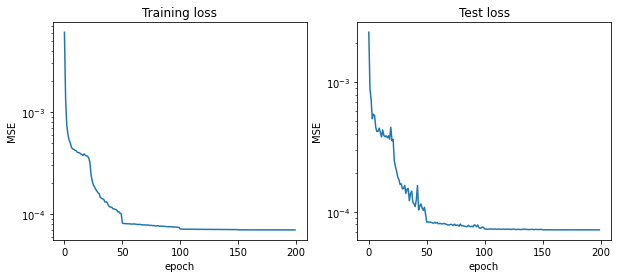

In [14]:
print_freq = 50
model = main_program(strain_tr, stress_tr, net_params, trainer_info, model_name)

In [19]:
#@title test data generator (No need to check this)

pre = 0
# model_monoincre.zero_state()
# model_monot.zero_state()

step_size = 0.001
# pre_comp = np.array([0, 0.00005])
comp1     = np.arange(0.0, 0.1, step_size)
comp2     = np.arange(0.1, -0.1, -step_size)
comp      = np.concatenate((comp1, comp2), axis=0)

zero_comp = np.zeros(len(comp))

temp      = np.stack((comp, -0.4 * comp, zero_comp, 2 * comp, zero_comp, zero_comp), axis=0)

strain_history = np.ndarray([temp.shape[1], temp.shape[0]])
strain_history = temp.T

print(strain_history.shape)

pre                     = 0
material1               = J2_material(Hp=5.3, E=60.0, r=1.2, nu=0.34)
stress_pred_rm          = np.zeros([1, len(comp), 6])
strain_history          = np.ndarray([1, temp.shape[1], temp.shape[0]])
strain_history[0, :, :] = temp.T
material_test           = np.ndarray([1, strain_history.shape[1], 4])

# print(strain_history.shape)

for time_step in range(strain_history.shape[1]):
    strain_inp                            = strain_history[0, pre:time_step+1, :]
    material1.return_map(strain_inp.T)
    stress_pred_rm[0, pre:time_step+1, :] = material1.sig.T
    material_test[0, time_step, :]        = np.array([material1.E, material1.nu, material1.Hp/(1+material1.Hp/material1.E), 1.2])
    pre                                   = time_step + 1

strain_test = strain_history.copy()

(300, 6)


/tmp/ipykernel_1234/2017569100.py:70: RuntimeWarning: invalid value encountered in true_divide
  n = xi_trial / X


In [20]:
strain_test.shape
strain_tr.shape

(30000, 200, 7)

In [21]:
#@title Prediction

# The orginal code produces strain series with six components, we only need three 
# of them since it's a 2d plane strain problem
strain_test_inp = np.concatenate((strain_test[:, :, [0, 1, 3]], material_test), axis=2)

# use min-max scaler to transform strain
strain_test_inp = strain_scaler.transform(strain_test_inp)

# the default datatype in torch is float32.
strain_test_inp.astype(np.float32)

# the input should be a tensor
inp = torch.Tensor(strain_test_inp).to(device)

# prediction
stress_pred = model(inp)

# Use the inverse transform of the data scaler to get the stress prediction
stress_pred = stress_scaler.inv_transform(stress_pred.cpu().detach().numpy())

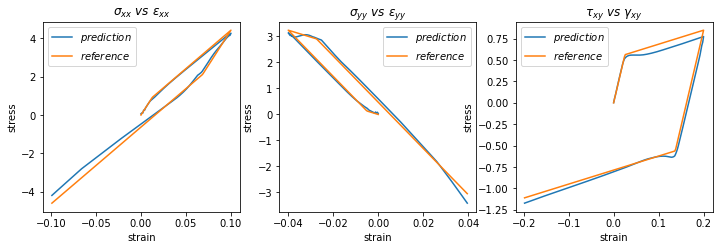

In [22]:
#@title Stress response given uniform strain series (No need to check this)
fig, ax = plt.subplots(1, 3, figsize=(12, 3.5))
ax[0].plot(strain_test[0, :, 0], stress_pred[0, :, 0], label='$prediction$')
ax[0].plot(strain_test[0, :, 0], stress_pred_rm[0, :, 0], label='$reference$')
ax[0].set_xlabel('strain')
ax[0].set_ylabel('stress')
ax[0].title.set_text('$\sigma_{xx}\ vs\ \epsilon_{xx}$')
ax[0].legend()

ax[1].plot(strain_test[0, :, 1], stress_pred[0, :, 1], label='$prediction$')
ax[1].plot(strain_test[0, :, 1], stress_pred_rm[0, :, 1], label='$reference$')
ax[1].set_xlabel('strain')
ax[1].set_ylabel('stress')
ax[1].title.set_text('$\sigma_{yy}\ vs\ \epsilon_{yy}$')
ax[1].legend()

ax[2].plot(strain_test[0, :, 3], stress_pred[0, :, 2], label='$prediction$')
ax[2].plot(strain_test[0, :, 3], stress_pred_rm[0, :, 3], label='$reference$')
ax[2].set_xlabel('strain')
ax[2].set_ylabel('stress')
ax[2].title.set_text('$\\tau_{xy}\ vs\ \gamma_{xy}$')
ax[2].legend()

plt.show()

<!-- **d)** (Extra Credit [25 points]- the points obtained from this problem will be added to the sum of all assignments)

The network in Part (c) is the default network. Conduct a grid search to find the optimal combination of these three hyperparameters.

* the number of GRU layers = $\{2, 3, 4\}$
* the number of hidden states = $\{20, 40, 60\}$
* activation function = $\{leaky\ ReLU, Sigmoid,\ Tanh\}$

There will be $3\times 3\times 3 = 27$ cases in total. Please double check if you have time to solve this problem- this problem will take a significant amount of time.

In each case, print the training/test loss and report the minimal test loss during the training. Use the minimal test loss to choose the best set of hyperparameters.


 -->